<a href="https://colab.research.google.com/github/ellahn3/Hackathon-CrimeSeen-/blob/main/image_classification_CrimeSeen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! git clone https://github.com/ellahn3/Hackathon-CrimeSeen-.git

Cloning into 'Hackathon-CrimeSeen-'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
!pip3 install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
!pip install scikit-learn

     |████████████████████████████████| 462 kB 5.0 MB/s 


In [ ]:
!pip install face_recognition
!pip install colorama 

     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=fb067df6405b5f17d5d8957d3042e8fdf52c91edd3a51189b63fb7062efa0037
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
#Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pylab as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ctrain_ds='/content/drive/MyDrive/hakaton/Data/train'
test_ds='/content/drive/MyDrive/hackaton/Data/test'
val_ds='/content/drive/MyDrive/hakaton/Data/val'

In [ ]:
test_with_gun=os.listdir(test_ds+'/with_gun')
test_without_gun=os.listdir(test_ds+'/without_gun')
print('test size test_with_gun ',len(test_with_gun))
print('test size test_without_gun ',len(test_without_gun))

test size test_with_gun  31
test size test_without_gun  33


In [ ]:
print('trian size with_gun',len(os.listdir(train_ds+'/with_gun')))
print('trian size without_gun',len(os.listdir(train_ds+'/without_gun')))


trian size with_gun 100
trian size without_gun 100


# model

In [ ]:
#ImageDataGenerator is a class that allows pre-processing of images,
#in order to format images before using them by training and drawing a model.
#This includes resizing, orientation and color corrections.
train_datagen= ImageDataGenerator(rescale = 1./255,validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen= ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen= ImageDataGenerator(rescale = 1./255)
# Rescale 1./255 -is to transform every pixel value from range [0,255] -> [0,1]
# width_shift_range -shift the image to the left or right(horizontal shifts)
#height_shift_range -shift the image to up or down (vertically shifts).
#shear_range is Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#rotation_range -randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = train_ds,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = val_ds,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 200 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [ ]:
#data batches
#!pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
!pip3 install --user scipy  # install using python3
import scipy
image_batch_train, label_batch_train = next(iter(train_dataset))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_dataset.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print('0: ',dataset_labels[0])
print('1: ',dataset_labels[1])


Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 2)
0:  With_Gun
1:  Without_Gun


In [ ]:
base_model_2 = tf.keras.applications.ResNet101V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
# Freezing Layers
for layer in base_model_2.layers:
   layer.trainable = False

171327488/171317808 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import optimizers
#The output of the CNN is also a 4D array. Where batch size would be the same as input batch size but the other 3 dimensions of the image might change depending upon the values of filter, kernel size, and padding we use.
x = base_model_2.output 
#A Flatten layer in Keras reshapes the tensor to have a shape that is equal to the number of elements contained in the tensor. This is the same thing as making a 1d-array of elements.
x = tf.keras.layers.Flatten()(x) 
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # Dropout 20 % of the layers
x = tf.keras.layers.Dense(train_dataset.num_classes, activation = "softmax")(x)
#The input layer is the input of the whole CNN.
model = Model(inputs= base_model_2.input , outputs = x)

checkpoint_filepath = './Data/ModelCheckpoint/'
# modelCheckpoint: a callback object that can perform actions at various stages of the training, and can monitor either the accuracy or the loss
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode="auto",min_delta=0.05,verbose=1)

callbacks_list = [early_stopping,checkpoint]

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='acc')
]
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,callbacks=callbacks_list,verbose = 1)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 14.1346 - accuracy: 0.7300 - precision: 0.7300 - recall: 0.7300 - acc: 0.8115 
Epoch 1: acc improved from -inf to 0.81145, saving model to ./Data/ModelCheckpoint/
4/4 [==============================] - 152s 35s/step - loss: 14.1346 - accuracy: 0.7300 - precision: 0.7300 - recall: 0.7300 - acc: 0.8115 - val_loss: 24.9033 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500 - val_acc: 0.7461
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 12.2305 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - acc: 0.8297 
Epoch 2: acc improved from 0.81145 to 0.82968, saving model to ./Data/ModelCheckpoint/
4/4 [==============================] - 78s 20s/step - loss: 12.2305 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - acc: 0.8297 - val_loss: 5.5493 - val_accuracy: 0.8594 - val_precision: 0.8594 - val_recall: 0.8594 - val_acc: 0.8728
Epoch 3/10
4/4 [==============================] - E

In [ ]:
#save model
model.save('/content/gdrive/MyDrive/hakaton/model5ep')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/hakaton/model5ep/assets


In [ ]:
y_pred=[]
model = keras.models.load_model('/content/gdrive/MyDrive/hakaton/model5ep')
'''This function loads an image'''
def prepare_img(img, img_width, img_height,channels):
    img =  tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img


for img in test_with_gun:
    img = load_img('/content/gdrive/MyDrive/hakaton/Data/test/with_gun/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())

for img in test_without_gun:
    img = load_img('/content/gdrive/MyDrive/hakaton/Data/test/without_gun/' + img ,target_size=(224, 224))
    img = prepare_img(img,224,224,3)
    predictions = model.predict(img)
    index_of_higher_value  = predictions[0].argmax()
    y_pred.append(predictions[0].argmax())


    

In [ ]:
y_test=[0]*len(test_with_gun)
y_test+=[1]*len(test_without_gun)
print('Accuracy: ',round(accuracy_score(y_test, y_pred),2))
print('Recall: ',round(recall_score(y_test, y_pred,average='weighted'),2))
print('Precision: ',round(precision_score(y_test, y_pred,average='weighted'),2))
print('f1 score :',round(f1_score(y_test,y_pred, average='weighted'),2))

print(classification_report(y_test, y_pred))

Accuracy:  0.98
Recall:  0.98
Precision:  0.99
f1 score : 0.98
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.97      1.00      0.99        33

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65



# face recognition

In [ ]:
import face_recognition
import cv2
import os
import glob
import numpy as np

class SimpleFacerec:
    def __init__(self):
        self.known_face_encodings = []
        self.known_face_names = []

        # Resize frame for a faster speed
        self.frame_resizing = 0.25

    def load_encoding_images(self, images_path):
        """
        Load encoding images from path
        :param images_path:
        :return:
        """
        # Load Images
        images_path = glob.glob(os.path.join(images_path, "*.*"))
        # Store image encoding and names
        for img_path in images_path:
            img = cv2.imread(img_path)
            rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get the filename only from the initial file path.
            basename = os.path.basename(img_path)
            (filename, ext) = os.path.splitext(basename)
            # Get encoding
            img_encoding = face_recognition.face_encodings(rgb_img)[0]

            # Store file name and file encoding
            self.known_face_encodings.append(img_encoding)
            self.known_face_names.append(filename)

    def detect_known_faces(self, frame):
        small_frame = cv2.resize(frame, (0, 0), fx=self.frame_resizing, fy=self.frame_resizing)
        # Find all the faces and face encodings in the current frame of video
        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        face_locations = face_recognition.face_locations(rgb_small_frame)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

        face_names = []
        for face_encoding in face_encodings:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(self.known_face_encodings, face_encoding)
            name = "Unknown"

            # # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            #     first_match_index = matches.index(True)
            #     name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(self.known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)
            if matches[best_match_index]:
                name = self.known_face_names[best_match_index]
            face_names.append(name)

        # Convert to numpy array to adjust coordinates with frame resizing quickly
        face_locations = np.array(face_locations)
        face_locations = face_locations / self.frame_resizing
        return face_locations.astype(int), face_names




In [ ]:
from keras.preprocessing.image import img_to_array
import colorama
from colorama import Fore
my_temp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
def prepare_img(img, img_width, img_height,channels):
    img =  tf.keras.preprocessing.image.img_to_array(img)
    img = img.reshape(1, img_width, img_height, channels).astype('float32')
    img = img / 255.0
    return img
def crimeseen(num):
  category=''
  if num in my_temp:
    category = 'with_gun'
    sample='/content/drive/MyDrive/hackaton/Data/test/with_gun/'+str(num)+'.jpg'
  else:
    category = 'without_gun'
    sample='/content/drive/MyDrive/hackaton/Data/test/without_gun/n'+str(num)+'.jpg'
  arr=sample.split('/')
  model = keras.models.load_model('/content/drive/MyDrive/hackaton/model5ep')
  img = load_img(sample ,target_size=(224, 224))
  image = prepare_img(img,224,224,3)
  predictions = model.predict(image)
  index_of_higher_value  = predictions[0].argmax()
  if index_of_higher_value == 0:# Encode faces from a folder
    sfr = SimpleFacerec() 
    sfr.load_encoding_images("/content/drive/MyDrive/hackaton/Data/faces/criminals/")
    frame =plt.imread("/content/drive/MyDrive/hackaton/Data/faces/random/"+arr[-1])# Detect Faces
    face_locations, face_names = sfr.detect_known_faces(frame)
    for face_loc, name in zip(face_locations, face_names):
          y1, x2, y2, x1 = face_loc[0], face_loc[1], face_loc[2], face_loc[3]
          cv2.putText(frame, name,(x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 0, 200), 2)
          cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 200), 4)
    if name !="Unknown":print(Fore.RED +"ALERT!ALERT! "+name+" is not supposed to walk around with a gun\n\n\n")
    else:print("Has a gun but is not a known criminal\n\n")
    plt.imshow(frame)
    plt.show()
    plt.imshow(img)
    plt.show()
  else:
      print("without gun no need to continue with face recognition:) ")
      plt.imshow(img)

### DATA:

The data contain 2 thypes of infrared images 

1- infrared images whit gun

2- infrared images whitout gun

3-criminal faces

### ResNet-50 Model:
ResNet-50 is a convolutional neural network that is 50 layers deep. ResNet, short for Residual Networks. The resnet 50 architecture contains the following element:

1.	A convoultion with a kernel size of 7 * 7 and 64 different kernels all with a stride of size 2 giving us 1 layer.
2.	Next we see max pooling with also a stride size of 2.
3.	In the next convolution there is a 1 * 1,64 kernel following this a 3 * 3,64 kernel and at last a 1 * 1,256 kernel, These three layers are repeated in total 3 time so giving us 9 layers in this step.
4.	Next we see kernel of 1 * 1,128 after that a kernel of 3 * 3,128 and at last a kernel of 1 * 1,512 this step was repeated 4 time so giving us 12 layers in this step.
5.	After that there is a kernal of 1 * 1,256 and two more kernels with 3 * 3,256 and 1 * 1,1024 and this is repeated 6 time giving us a total of 18 layers.
6.	And then again a 1 * 1,512 kernel with two more of 3 * 3,512 and 1 * 1,2048 and this was repeated 3 times giving us a total of 9 layers.
7.	After that we do a average pool and end it with a fully connected layer containing 1000 nodes and at the end a softmax function so this gives us 1 layer.


We don't actually count the activation functions and the max/ average pooling layers.

so totaling this it gives us a 1 + 9 + 12 + 18 + 9 + 1 = 50 layers Deep Convolutional network.

### face recognition:

unknown image=> model for infrared images=>face recognition


# New section


give me a random number [1-62]

9
ALERT!ALERT! the god father gen2 is not supposed to walk around with a gun





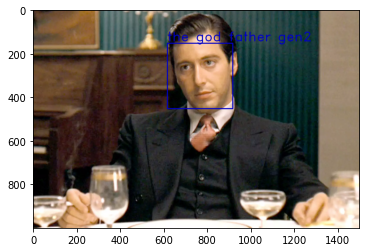

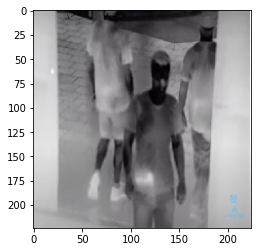

In [ ]:
 my_time=input("\ngive me a random number [1-62]\n\n")
crimeseen(int(my_time))